In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from uncertainty_forest.uncertainty_forest import UncertaintyForest
from tqdm import tqdm_notebook

In [2]:
def generate_data(n, mean, var):
    y = 2 * np.random.binomial(1, .5, n) - 1 # classes are -1 and 1.
    X = np.random.multivariate_normal(mean * y, var * np.eye(n), 1).T
    return X, y

In [3]:
# Estimate posteriors for many trials and evaluate in the given X_eval range.
def estimate_posterior(algo, n, mean, var, num_trials, X_eval):
    predicted_posterior = np.zeros((num_trials, X_eval.shape[0]))
    obj = algo['instance']
    for t in tqdm_notebook(range(num_trials)):
        X, y = generate_data(n, mean, var)
        obj.fit(X, y)
        class_1_index = np.argwhere(obj.classes_.ravel() == 1)[0][0]
        predicted_posterior[t, :] = obj.predict_proba(X_eval)[:, class_1_index]
    
    return predicted_posterior

In [20]:
# For either a CART, Honest, or Uncertainty Forest, plot P(Y = 1 | X = x).
def plot_posterior(ax, algo, num_plotted_trials, X_eval):
    
    # Plot each of num_plotted_trials iterations, highlighting a single line.
    for i in range(num_plotted_trials):
        linewidth = 1
        opacity = .3
        if i == num_plotted_trials - 1:
            opacity = 1
            linewidth = 4
        ax.set_title(algo['title'])
        ax.plot(X_eval.flatten().ravel(), algo['predicted_posterior'][i, :].ravel(), 
                label = algo['label'],
                linewidth = linewidth, 
                color = algo['color'], 
                alpha = opacity)

# Plot the variance over the number of trials.
def plot_variance(ax, algos, X_eval):
    ax.set_title('Variance of Posterior')
    for algo in algos:
        variance = np.var(algo['predicted_posterior'], axis = 0)
        ax.plot(X_eval.flatten().ravel(), variance.ravel(), 
                label = algo['label'],
                linewidth = 4, 
                color = algo['color'])

In [13]:
# Communal plotting parameters.
def plot_fig1(algos, num_plotted_trials):
    sns.set(font_scale = 6)
    sns.set_style("ticks")
    plt.rcParams['figure.figsize'] = [55, 14]
    fig, axes = plt.subplots(1, 4)
    for ax in axes:
        ax.set_xlim(-2.1, 2.1)
        ax.set_ylim(-0.05, 1.05)

    # 3 posterior plots.
    for i in range(len(algos)):
        plot_posterior(axes[i], 
                       algos[i],
                       num_plotted_trials, 
                       X_eval)

    # 1 variance plot.
    axes[3].set_ylim(-0.05, 0.1)
    plot_variance(axes[3], algos, X_eval)
    
    fig.tight_layout()
    plt.show()

In [17]:
# Data.
n = 30
mean = 1
var = 1
num_trials = 5
X_eval = np.linspace(-2, 2, num = 50).reshape(-1, 1)

# Algorithms.
algos = [
    {
        'instance': UncertaintyForest(parallel = True, n_estimators = 1000),
        'label': 'CART',
        'title': 'CART Forest',
        'color': "#1b9e77",
    },
    {
        'instance': UncertaintyForest(parallel = False),
        'label': 'Honest',
        'title': 'Honest Forest',
        'color': "#fdae61",
    },
    {
        'instance': UncertaintyForest(parallel = False),
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

# Plotting parameters.
num_plotted_trials = 5

In [18]:
# Generate data and predictions.
# TO DO: Remove.
predicted_posterior = estimate_posterior(algos[1], n, mean, var, num_trials, X_eval)

for algo in algos:
    # algo['predicted_posterior'] = estimate_posterior(algo, n, mean, var, num_trials, X_eval)
    algo['predicted_posterior'] = predicted_posterior

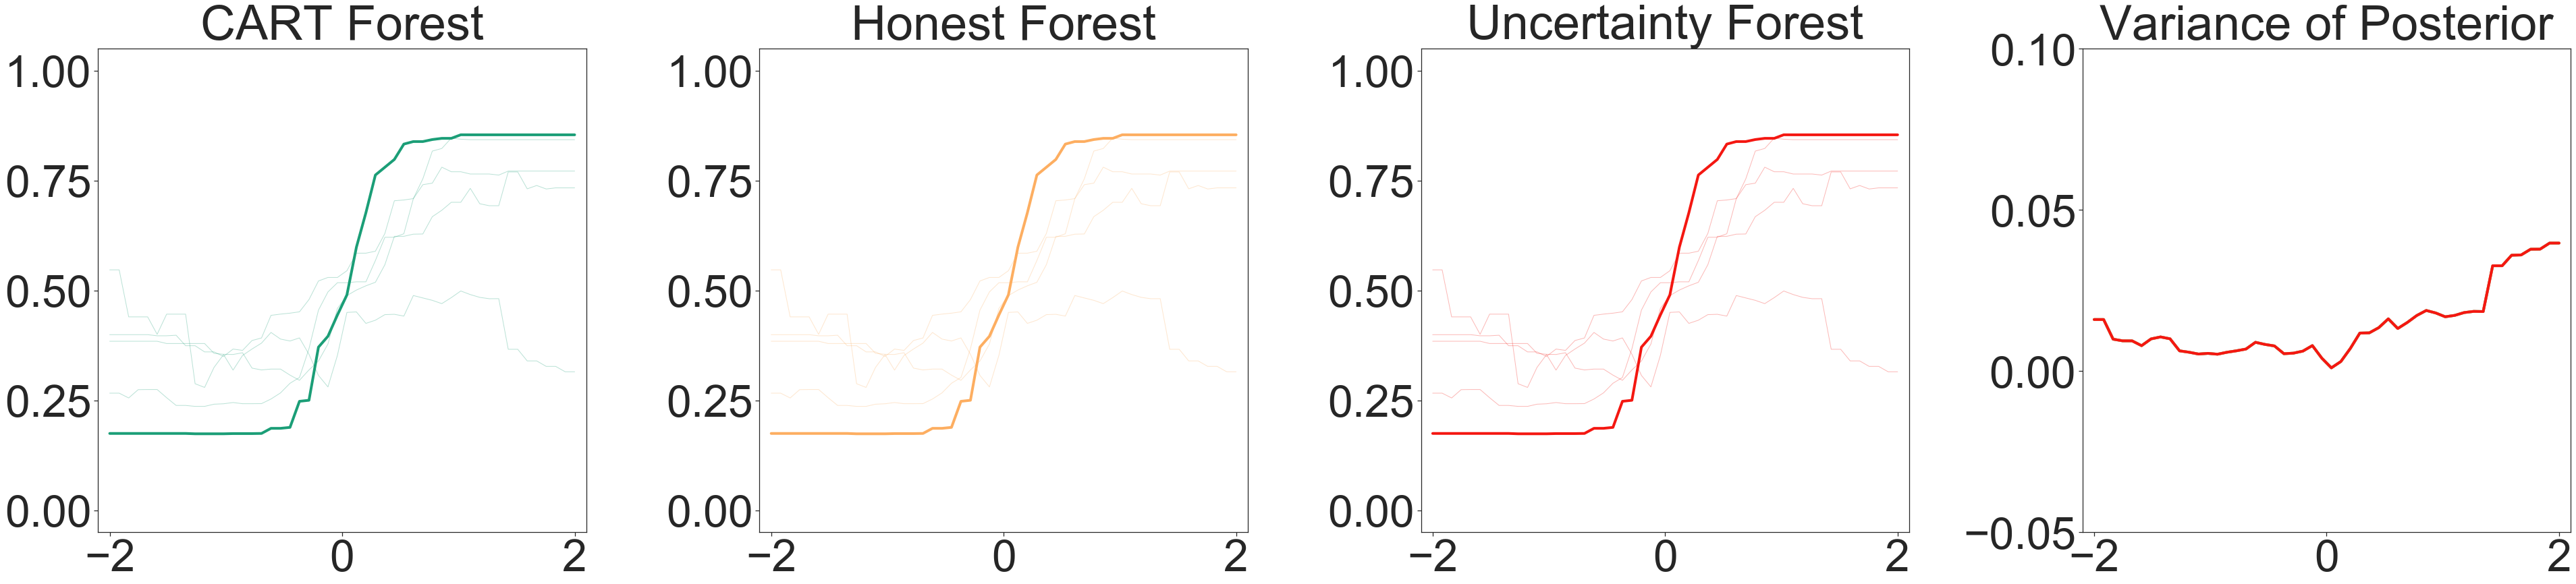

In [19]:
plot_fig1(algos, num_plotted_trials)